Epoch 1/10


2023-12-14 12:48:29.341524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 29ms/step - loss: 3.9075 - accuracy: 0.1632
Epoch 2/10
14/14 [==============================] - 0s 15ms/step - loss: 2.9057 - accuracy: 0.3494
Epoch 3/10
14/14 [==============================] - 0s 16ms/step - loss: 1.3829 - accuracy: 0.6115
Epoch 4/10
14/14 [==============================] - 0s 18ms/step - loss: 0.7618 - accuracy: 0.8023
Epoch 5/10
14/14 [==============================] - 0s 15ms/step - loss: 0.5081 - accuracy: 0.8667
Epoch 6/10
14/14 [==============================] - 0s 14ms/step - loss: 0.3651 - accuracy: 0.8943
Epoch 7/10
14/14 [==============================] - 0s 17ms/step - loss: 0.1864 - accuracy: 0.9609
Epoch 8/10
14/14 [==============================] - 0s 15ms/step - loss: 0.0986 - accuracy: 0.9701
Epoch 9/10
14/14 [==============================] - 0s 17ms/step - loss: 0.0364 - accuracy: 0.9908
Epoch 10/10
14/14 [==============================] - 0s 14ms/step - loss: 0.0096 - accuracy: 1.0000


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
2023-12-14 12:48:31.946220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-14 12:48:33.450160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-14 12:48:34.642975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-14 12:48:35.820460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.

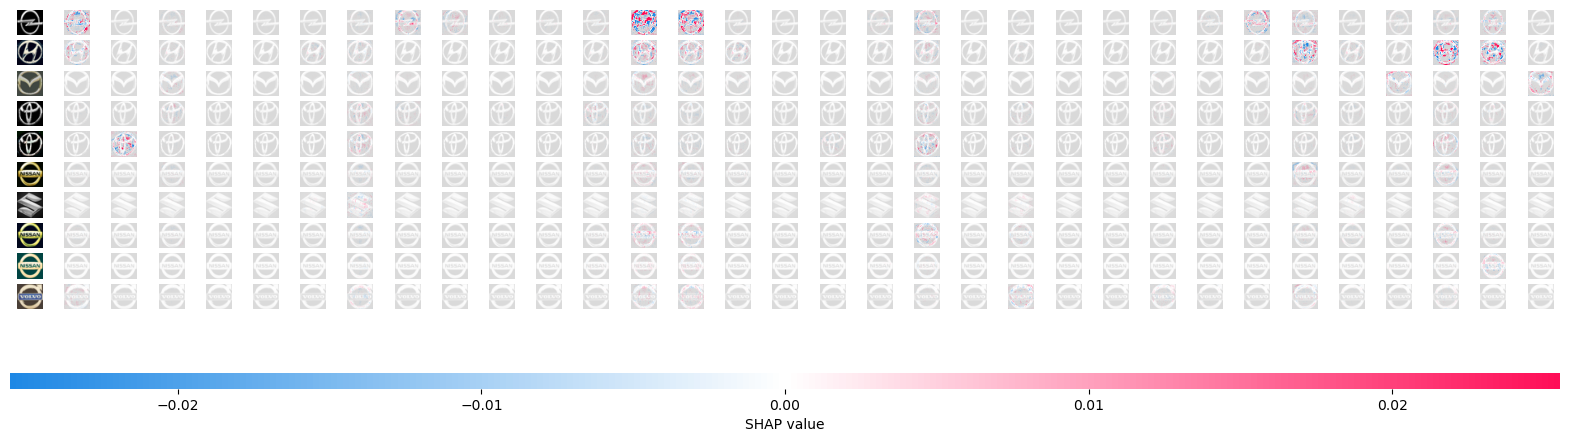

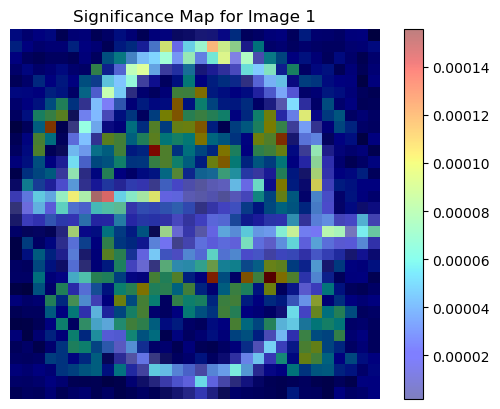

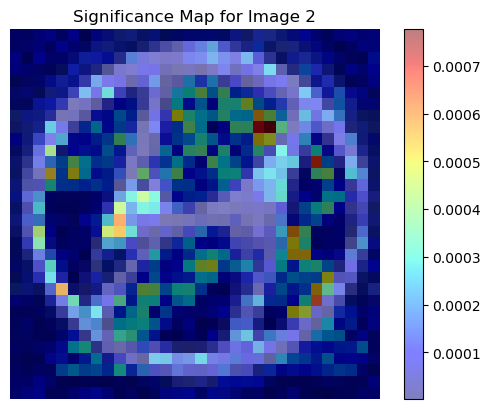

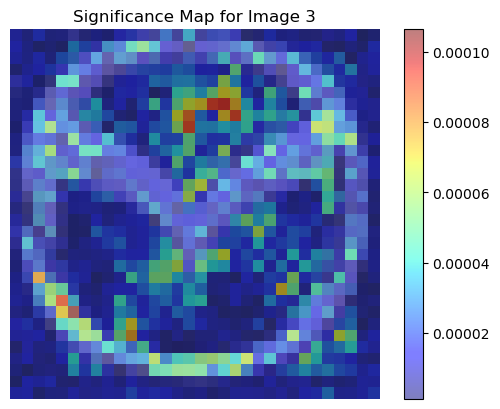

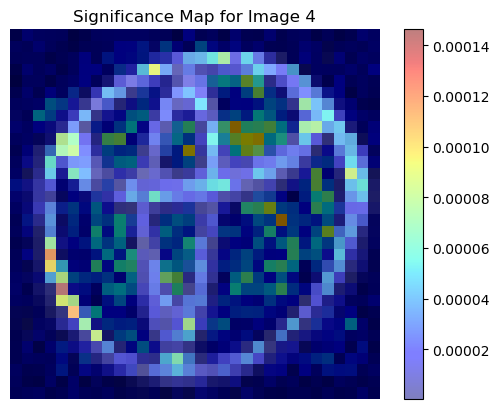

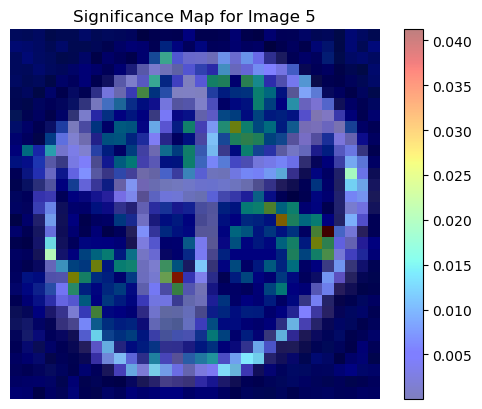

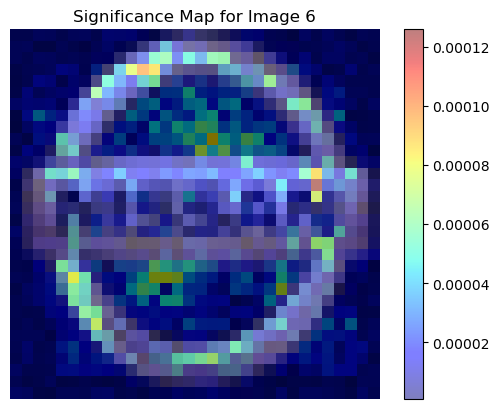

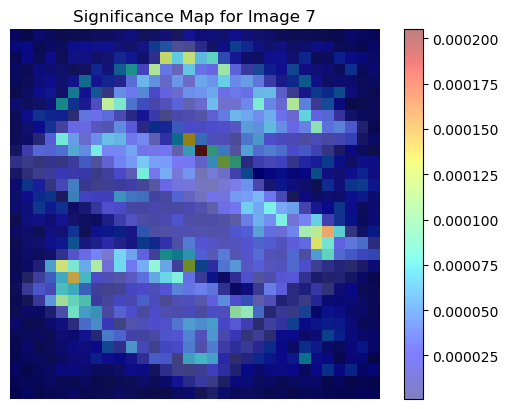

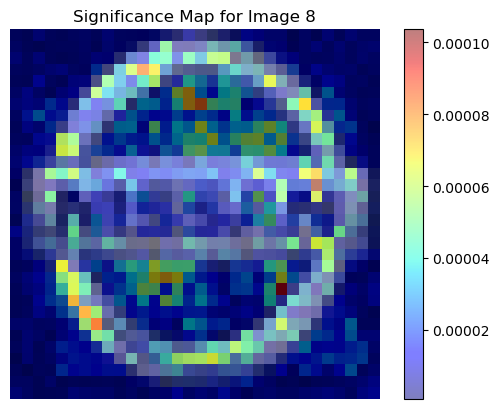

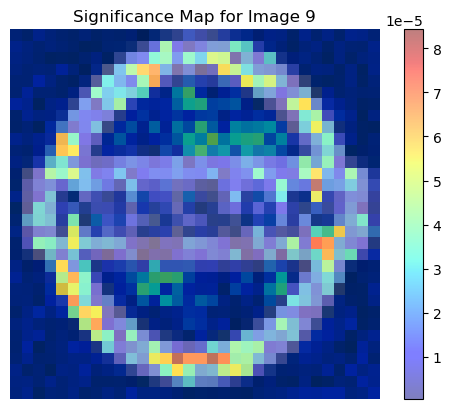

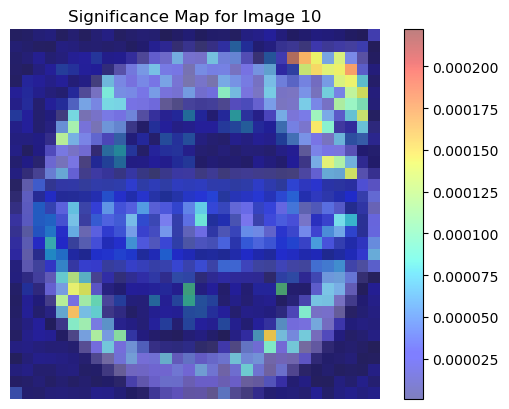

In [2]:
from sklearn.model_selection import train_test_split
import glob
import numpy as np
import os
import tensorflow as tf
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt  # 导入matplotlib绘制显著性图

# 图片加载函数
def load_images(image_paths, target_size=(32, 32)):
    images = []
    labels = []
    for image_path in image_paths:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img)
        images.append(img_array)
        label = os.path.basename(os.path.dirname(image_path))
        labels.append(label)
    images = np.array(images, dtype='float32') / 255.0
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = tf.keras.utils.to_categorical(labels)
    return images, labels

# 载入数据
image_paths = glob.glob('Car_Logo_Dataset/**/*.png', recursive=True)
X, y = load_images(image_paths)

# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 构建ANN模型
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='softmax')  # 32个类别
])

# 编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(X_train, y_train, epochs=10)

# 使用SHAP进行可视化
explainer = shap.DeepExplainer(model, X_train[:100])
shap_values = explainer.shap_values(X_test[:10])

# 使用shap.image_plot进行可视化
shap.image_plot(shap_values, X_test[:10])

# 生成显著性图
def plot_significance(shap_values, X_test_sample):
    # 对于SHAP返回的值，我们取正类的预测值（通常是index 1）
    shap_image_vals = np.abs(shap_values[1]).sum(axis=-1)
    for i in range(len(shap_image_vals)):
        plt.imshow(X_test_sample[i], cmap='gray')
        plt.imshow(shap_image_vals[i], cmap='jet', alpha=0.5)
        plt.colorbar()
        plt.title('Significance Map for Image {}'.format(i+1))
        plt.axis('off')
        plt.show()

# 显示测试集前10个样本的显著性图
plot_significance(shap_values, X_test[:10])
